# Random Forest Classifier: Total_Sales < 1 M

## To predict the class of the low total sales based on different features
The majority of the games that has total sales less than 1 millions and is categorized as low total sales, are extracted to be used as the input data for this model to predict whether the class of the low total sales are '0' (total sales < 0.2 M) or '1' (0.2 M < total sales < 1 M), and to determine whether the the importance of the feature variables differ from the first model where the input data includes all total sales, both low and high (from 0.01 - 82.86 millions).

### Target Variable and Features
- Target variable (y) = Low_Sales_Class
- X = Critic_Score, Genre, ESRB_Rating, Platform, Publisher, Developer_x

### Machine Learning Models
- rf_model = RandomForestClassifier
- brf_model = BalancedRandomForestClassifier
- eec_model = EasyEnsembleClassifier


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [2]:
# Load the dataset from AWS S3 bucket
#games_df = pd.read_csv('https://video-game-dataset-uot-boot-camp-2022-group-4.s3.us-east-2.amazonaws.com/all_columns_df.csv')
games_df = pd.read_csv('Cleaned_Data/all_columns_df.csv')
games_df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006.0,Japan,82.86
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985.0,Japan,40.24
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008.0,Japan,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017.0,NaN,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009.0,Japan,33.09
...,...,...,...,...,...,...,...,...,...,...,...,...
19857,19858,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004.0,NaN,0.01
19858,19859,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003.0,Europe,0.01
19859,19860,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002.0,Japan,0.01
19860,19861,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017.0,NaN,0.01


In [3]:
games_df.dtypes

Rank              int64
Name             object
Genre            object
ESRB_Rating      object
Platform         object
Publisher        object
Developer_x      object
Critic_Score    float64
User_Score      float64
Year            float64
Country          object
Total_Sales     float64
dtype: object

In [4]:
# Change 'Year' dtype to object
games_df['Year'] = pd.to_datetime(games_df['Year'], format = '%Y').dt.strftime('%Y')
games_df.dtypes

Rank              int64
Name             object
Genre            object
ESRB_Rating      object
Platform         object
Publisher        object
Developer_x      object
Critic_Score    float64
User_Score      float64
Year             object
Country          object
Total_Sales     float64
dtype: object

In [5]:
# Drop columns that won't be included in the analysis
games_df.drop(['Rank'], axis=1, inplace=True)
games_df

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006,Japan,82.86
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985,Japan,40.24
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008,Japan,37.14
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017,NaN,36.60
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009,Japan,33.09
...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01


In [6]:
# Sattistics of the Total_Sales column
games_df.describe()

,Critic_Score,User_Score,Total_Sales
count,4706.000000,238.000000,19862.000000
mean,7.269911,8.465546,0.530876
std,1.420956,1.215681,1.572634
min,1.000000,2.000000,0.010000
25%,6.500000,8.000000,0.050000
50%,7.500000,8.800000,0.160000
75%,8.300000,9.300000,0.450000
max,10.000000,10.000000,82.860000


## Bin Total_Sales and Create 'Total_Sales_Class' column

In [7]:
# Create bin for 'Total_Sales' column
bins = [0,1,10,100]
labels = ['low', 'medium', 'high']

In [8]:
# Bin 'Total_Sales' into new column
games_df['Total_Sales_Class'] = pd.cut(games_df['Total_Sales'], bins=bins, labels=labels, right=False)
games_df

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales,Total_Sales_Class
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006,Japan,82.86,high
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985,Japan,40.24,high
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008,Japan,37.14,high
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017,NaN,36.60,high
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009,Japan,33.09,high
...,...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01,low
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01,low
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01,low
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01,low


In [9]:
games_df.Total_Sales_Class.value_counts()

low       17420
medium     2355
high         87
Name: Total_Sales_Class, dtype: int64

## Look at the low total_sales (Total_Sales < 1M)

In [10]:
low_sales_df = games_df.loc[games_df['Total_Sales_Class'] == 'low']
low_sales_df

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales,Total_Sales_Class
2442,NFL Fever 2002,Sports,E,XB,Microsoft,Microsoft,NaN,NaN,2001,United States,0.99,low
2443,Haze,Shooter,M,PS3,Ubisoft,Free Radical Design,5.6,NaN,2008,Europe,0.99,low
2444,The Simpsons: Hit & Run,Racing,T,GC,VU Games,Radical Entertainment,8.2,NaN,2003,NaN,0.99,low
2445,Oddworld: Abe's Exoddus,Platform,T,PS,GT Interactive,Oddworld Inhabitans,8.6,NaN,1998,NaN,0.99,low
2446,Tales of Graces f,Role-Playing,T,PS3,Namco Bandai,Namco Tales Studio,NaN,8.0,2012,Japan,0.99,low
...,...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01,low
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01,low
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01,low
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01,low


In [11]:
low_sales_df.count()

Name                 17420
Genre                17420
ESRB_Rating          11820
Platform             17420
Publisher            17420
Developer_x          17418
Critic_Score          3405
User_Score             107
Year                 17417
Country               9868
Total_Sales          17420
Total_Sales_Class    17420
dtype: int64

In [12]:
low_sales_df.describe()

,Critic_Score,User_Score,Total_Sales
count,3405.000000,107.000000,17420.000000
mean,6.956035,8.060748,0.210579
std,1.409481,1.331247,0.221424
min,1.000000,2.000000,0.010000
25%,6.200000,7.600000,0.050000
50%,7.200000,8.200000,0.130000
75%,8.000000,9.000000,0.300000
max,9.700000,10.000000,0.990000


In [13]:
low_sales_df.drop(['Total_Sales_Class'], axis=1, inplace=True)
low_sales_df

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/3973297669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df.drop(['Total_Sales_Class'], axis=1, inplace=True)


,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
2442,NFL Fever 2002,Sports,E,XB,Microsoft,Microsoft,NaN,NaN,2001,United States,0.99
2443,Haze,Shooter,M,PS3,Ubisoft,Free Radical Design,5.6,NaN,2008,Europe,0.99
2444,The Simpsons: Hit & Run,Racing,T,GC,VU Games,Radical Entertainment,8.2,NaN,2003,NaN,0.99
2445,Oddworld: Abe's Exoddus,Platform,T,PS,GT Interactive,Oddworld Inhabitans,8.6,NaN,1998,NaN,0.99
2446,Tales of Graces f,Role-Playing,T,PS3,Namco Bandai,Namco Tales Studio,NaN,8.0,2012,Japan,0.99
...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01


## Bin the Low Total_Sales to class 0 and 1

In [14]:
# Create bin for 'Total_Sales' column
bins = [0,0.2,1]
labels = ['0', '1']

In [15]:
# Bin 'Total_Sales' into new column
low_sales_df['Low_Sales_Class'] = pd.cut(low_sales_df['Total_Sales'], bins=bins, labels=labels, right=False)
low_sales_df

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/2009934261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df['Low_Sales_Class'] = pd.cut(low_sales_df['Total_Sales'], bins=bins, labels=labels, right=False)


,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales,Low_Sales_Class
2442,NFL Fever 2002,Sports,E,XB,Microsoft,Microsoft,NaN,NaN,2001,United States,0.99,1
2443,Haze,Shooter,M,PS3,Ubisoft,Free Radical Design,5.6,NaN,2008,Europe,0.99,1
2444,The Simpsons: Hit & Run,Racing,T,GC,VU Games,Radical Entertainment,8.2,NaN,2003,NaN,0.99,1
2445,Oddworld: Abe's Exoddus,Platform,T,PS,GT Interactive,Oddworld Inhabitans,8.6,NaN,1998,NaN,0.99,1
2446,Tales of Graces f,Role-Playing,T,PS3,Namco Bandai,Namco Tales Studio,NaN,8.0,2012,Japan,0.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01,0
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01,0
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01,0
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01,0


In [16]:
low_sales_df.Low_Sales_Class.value_counts()

0    10931
1     6489
Name: Low_Sales_Class, dtype: int64

## Dropping NaNs

In [17]:
# Drop unnecessary columns
low_sales_df.drop(['Name','User_Score', 'Total_Sales', 'Country', 'Year'], axis=1, inplace=True)
low_sales_df

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/2294208754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df.drop(['Name','User_Score', 'Total_Sales', 'Country', 'Year'], axis=1, inplace=True)


,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Low_Sales_Class
2442,Sports,E,XB,Microsoft,Microsoft,NaN,1
2443,Shooter,M,PS3,Ubisoft,Free Radical Design,5.6,1
2444,Racing,T,GC,VU Games,Radical Entertainment,8.2,1
2445,Platform,T,PS,GT Interactive,Oddworld Inhabitans,8.6,1
2446,Role-Playing,T,PS3,Namco Bandai,Namco Tales Studio,NaN,1
...,...,...,...,...,...,...,...
19857,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,0
19858,Shooter,T,PC,Ubisoft,Ubisoft,NaN,0
19859,Fighting,NaN,PS2,Capcom,Capcom,NaN,0
19860,Adventure,NaN,PSV,Rejet,Rejet,NaN,0


In [18]:
low_sales_df.dropna().count()

Genre              3294
ESRB_Rating        3294
Platform           3294
Publisher          3294
Developer_x        3294
Critic_Score       3294
Low_Sales_Class    3294
dtype: int64

In [19]:
# Drop all NaNs values
low_sales_df = low_sales_df.dropna()
print(low_sales_df.shape)

(3294, 7)


## Bucket data to top 10 and other bins

In [20]:
# Check unique values
low_sales_df.nunique()

Genre               19
ESRB_Rating          5
Platform            24
Publisher          206
Developer_x        965
Critic_Score        83
Low_Sales_Class      2
dtype: int64

In [21]:
# Keep top 14 of Genre
top = low_sales_df.Genre.value_counts().index[0:14]
low_sales_df.Genre = np.where(low_sales_df.Genre.isin(top), low_sales_df.Genre,'other')

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/2354053309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df.Genre = np.where(low_sales_df.Genre.isin(top), low_sales_df.Genre,'other')


In [22]:
# Keep top 18 of Platform
top = low_sales_df.Platform.value_counts().index[0:18]
low_sales_df.Platform = np.where(low_sales_df.Platform.isin(top), low_sales_df.Platform,'other')

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/658761553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df.Platform = np.where(low_sales_df.Platform.isin(top), low_sales_df.Platform,'other')


In [23]:
# Keep top 15 of Publisher
top = low_sales_df.Publisher.value_counts().index[0:15]
low_sales_df.Publisher = np.where(low_sales_df.Publisher.isin(top), low_sales_df.Publisher, 'other')

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/1291029336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df.Publisher = np.where(low_sales_df.Publisher.isin(top), low_sales_df.Publisher, 'other')


In [24]:
# Keep top 15 of Developer_x
top = low_sales_df.Developer_x.value_counts().index[0:15]
low_sales_df.Developer_x = np.where(low_sales_df.Developer_x.isin(top), low_sales_df.Developer_x,'other')

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/741136235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sales_df.Developer_x = np.where(low_sales_df.Developer_x.isin(top), low_sales_df.Developer_x,'other')


In [25]:
low_sales_df

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Low_Sales_Class
2443,Shooter,M,PS3,Ubisoft,other,5.6,1
2444,Racing,T,GC,other,other,8.2,1
2445,Platform,T,PS,other,other,8.6,1
2447,Racing,T,PS3,other,other,8.8,1
2450,Adventure,T,DS,Capcom,Capcom,8.0,1
...,...,...,...,...,...,...,...
19790,Fighting,T,other,other,other,8.4,0
19792,Shooter,T,PC,Activision,other,7.0,0
19794,Action,E,GBA,Atlus,Atlus Co.,6.0,0
19800,Puzzle,E,GBA,other,other,6.7,0


In [26]:
# Check unique values
low_sales_df.nunique()

Genre              15
ESRB_Rating         5
Platform           19
Publisher          16
Developer_x        16
Critic_Score       83
Low_Sales_Class     2
dtype: int64

## Encoding categorical variables

In [27]:
# Assign features
X = low_sales_df.drop('Low_Sales_Class', axis = 1)
X

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score
2443,Shooter,M,PS3,Ubisoft,other,5.6
2444,Racing,T,GC,other,other,8.2
2445,Platform,T,PS,other,other,8.6
2447,Racing,T,PS3,other,other,8.8
2450,Adventure,T,DS,Capcom,Capcom,8.0
...,...,...,...,...,...,...
19790,Fighting,T,other,other,other,8.4
19792,Shooter,T,PC,Activision,other,7.0
19794,Action,E,GBA,Atlus,Atlus Co.,6.0
19800,Puzzle,E,GBA,other,other,6.7


In [28]:
X.dtypes

Genre            object
ESRB_Rating      object
Platform         object
Publisher        object
Developer_x      object
Critic_Score    float64
dtype: object

In [29]:
# Encoding object dtype columns
X_cat = X.select_dtypes(include='object')
X_cat = list(X_cat.columns)
X_cat

['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer_x']

In [30]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(X[X_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(X_cat)

encode_df

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Developer_x_Neversoft Entertainment,Developer_x_Omega Force,Developer_x_Sonic Team,Developer_x_Square Enix,Developer_x_Traveller's Tales,Developer_x_Ubisoft,Developer_x_Ubisoft Montreal,Developer_x_Vicarious Visions,Developer_x_Visual Concepts,Developer_x_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3291,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
# Reset X dataframe index to merge with encode_df
X.reset_index(drop=True, inplace=True)
X

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score
0,Shooter,M,PS3,Ubisoft,other,5.6
1,Racing,T,GC,other,other,8.2
2,Platform,T,PS,other,other,8.6
3,Racing,T,PS3,other,other,8.8
4,Adventure,T,DS,Capcom,Capcom,8.0
...,...,...,...,...,...,...
3289,Fighting,T,other,other,other,8.4
3290,Shooter,T,PC,Activision,other,7.0
3291,Action,E,GBA,Atlus,Atlus Co.,6.0
3292,Puzzle,E,GBA,other,other,6.7


In [32]:
# Merge one-hot encoded features and drop the originals
X = X.merge(encode_df, left_index=True, right_index=True)
X = X.drop(X_cat,1)
X

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_87875/2670095812.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop(X_cat,1)


,Critic_Score,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,...,Developer_x_Neversoft Entertainment,Developer_x_Omega Force,Developer_x_Sonic Team,Developer_x_Square Enix,Developer_x_Traveller's Tales,Developer_x_Ubisoft,Developer_x_Ubisoft Montreal,Developer_x_Vicarious Visions,Developer_x_Visual Concepts,Developer_x_other
0,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,8.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3290,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3291,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3292,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
# Assign the target
y = low_sales_df['Low_Sales_Class']
y.value_counts()

1    1902
0    1392
Name: Low_Sales_Class, dtype: int64

In [34]:
print(X.shape)
print(y.shape)

(3294, 72)
(3294,)


## Spliting and scale the data

In [35]:
# Split data to training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Check the balance of the target variables.
print(f"y_train: {Counter(y_train)}")
print(f"y_test: {Counter(y_test)}")

y_train: Counter({'1': 1428, '0': 1042})
y_test: Counter({'1': 474, '0': 350})


In [36]:
# Creating a StandardScaler instance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest Classifier Model

In [37]:
# Create a random forest classifier.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [38]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [39]:
# Making predictions using the testing data.
y_pred_rf = rf_model.predict(X_test_scaled)

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred_rf)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,220,130
Actual 1,115,359


In [43]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred_rf)

In [44]:
# Displaying results
#print("Confusion Matrix")
#display(cm_df)
print('Model: Random Forest Classifier')
print("---------------------")
print(f"Accuracy Score : {acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report(y_test, y_pred_rf))

Model: Random Forest Classifier
---------------------
Accuracy Score : 0.7026699029126213
---------------------
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       350
           1       0.73      0.76      0.75       474

    accuracy                           0.70       824
   macro avg       0.70      0.69      0.69       824
weighted avg       0.70      0.70      0.70       824



In [45]:
# Calculate feature importance in the Random Forest model.
print("Feature Importance: rf model:")
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

Feature Importance: rf model:


[(0.29433130367620247, 'Critic_Score'),
 (0.03727064916844844, 'Publisher_other'),
 (0.0259763639505899, 'Platform_PC'),
 (0.024797681675990318, 'Platform_PS3'),
 (0.024178445832357794, 'ESRB_Rating_T'),
 (0.023768582859098907, 'Genre_Action'),
 (0.023644894623817518, 'Platform_GBA'),
 (0.019791452577230466, 'ESRB_Rating_E'),
 (0.018741582650858398, 'Platform_X360'),
 (0.018215154331991758, 'Genre_Role-Playing'),
 (0.016964280421676466, 'ESRB_Rating_E10'),
 (0.0169359337401082, 'Genre_Shooter'),
 (0.016897353686649474, 'Genre_Platform'),
 (0.01679100446947177, 'Platform_GC'),
 (0.016723039669368972, 'Developer_x_other'),
 (0.01661963318443852, 'ESRB_Rating_M'),
 (0.01628177473095908, 'Platform_PSP'),
 (0.014343435047989007, 'Platform_PS2'),
 (0.01419553096442712, 'Genre_Sports'),
 (0.013869228165673776, 'Platform_DS'),
 (0.013599153256151344, 'Genre_Racing'),
 (0.013270271396806645, 'Platform_Wii'),
 (0.013184437626232929, 'Genre_Adventure'),
 (0.012990411973917121, 'Publisher_Electron

(0.0, 0.35)

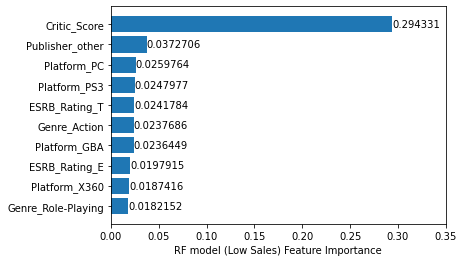

In [48]:
sorted_idx = rf_model.feature_importances_.argsort()[-10:]
x = X.columns[sorted_idx]
y = rf_model.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("RF model (Low Sales) Feature Importance")
plt.xlim(0.0,0.35)

## Balanced Random Forest Classifier Model

In [49]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(n_estimators=128, random_state = 78) 

# Fitting the model
brf_model.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=128, random_state=78)

In [50]:
# Calculated the balanced accuracy score
y_pred_brf = brf_model.predict(X_test)

from sklearn.metrics import balanced_accuracy_score
brf_acc_score = balanced_accuracy_score(y_test, y_pred_brf)

In [52]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_pred_brf),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
Actual 0,237,113
Actual 1,147,327


In [53]:
# Print the imbalanced classification report
print('Model: Balanced Random Forest Classifier')
print("---------------------")
print(f"Accuracy Score : {brf_acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_brf))

Model: Balanced Random Forest Classifier
---------------------
Accuracy Score : 0.6835081374321881
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.62      0.68      0.69      0.65      0.68      0.47       350
          1       0.74      0.69      0.68      0.72      0.68      0.47       474

avg / total       0.69      0.68      0.68      0.69      0.68      0.47       824



In [54]:
# Calculate feature importance in the Random Forest model.
print("Feature Importance: brf model: ")
sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)

Feature Importance: brf model: 


[(0.28048116014135555, 'Critic_Score'),
 (0.038143900076111965, 'Publisher_other'),
 (0.028450383822389846, 'Platform_PS3'),
 (0.02407443857101144, 'Platform_PC'),
 (0.022509556505393734, 'Genre_Action'),
 (0.022483951272352958, 'ESRB_Rating_T'),
 (0.021565693109226586, 'Platform_GBA'),
 (0.020891050987920587, 'ESRB_Rating_E'),
 (0.020368678771933744, 'Platform_X360'),
 (0.01825898959820314, 'ESRB_Rating_E10'),
 (0.01785997488064052, 'Genre_Role-Playing'),
 (0.017674561242787497, 'ESRB_Rating_M'),
 (0.017303112244664284, 'Genre_Platform'),
 (0.017119810824733003, 'Developer_x_other'),
 (0.017098679138276573, 'Genre_Shooter'),
 (0.016833573346124793, 'Platform_GC'),
 (0.016274653593219748, 'Platform_PSP'),
 (0.014964335867128926, 'Genre_Sports'),
 (0.014834186360338423, 'Platform_PS2'),
 (0.014537522601789936, 'Genre_Racing'),
 (0.01444520357195589, 'Platform_Wii'),
 (0.014286135726525736, 'Platform_DS'),
 (0.013045725416477794, 'Publisher_Electronic Arts'),
 (0.012984823401108491, 'Gen

(0.0, 0.35)

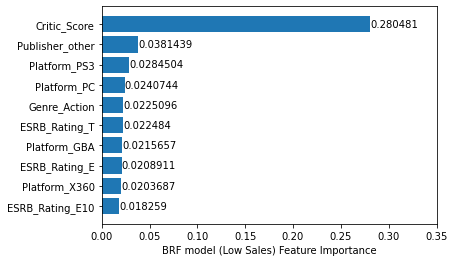

In [55]:
sorted_idx = brf_model.feature_importances_.argsort()[-10:]
x = X.columns[sorted_idx]
y = brf_model.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("BRF model (Low Sales) Feature Importance")
plt.xlim(0.0,0.35)

## Easy Ensemble AdaBoost Classifier Model

In [56]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

eec_model = EasyEnsembleClassifier(n_estimators=128, random_state=78)

eec_model.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=128, random_state=78)

In [57]:
# Calculated the balanced accuracy score
y_pred_eec = eec_model.predict(X_test)

eec_acc_score = balanced_accuracy_score(y_test, y_pred_eec)

In [58]:
# Display the confusion matrix
pd.DataFrame(
    confusion_matrix(y_test, y_pred_eec),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
Actual 0,252,98
Actual 1,155,319


In [59]:
# Print the imbalanced classification report
print('Model: EasyEnsembleClassifier')
print("---------------------")
print(f"Accuracy Score : {eec_acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_eec))

Model: EasyEnsembleClassifier
---------------------
Accuracy Score : 0.6964978902953587
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.62      0.72      0.67      0.67      0.70      0.49       350
          1       0.76      0.67      0.72      0.72      0.70      0.48       474

avg / total       0.70      0.69      0.70      0.69      0.70      0.48       824

